In [1]:
from gGA.utils.wannier import get_wannier_blocks
from ase.io import read
import numpy as np
from gGA.data import AtomicData, AtomicDataDict, OrbitalMapper
from gGA.data.interfaces import block_to_feature
from gGA.gutz.hr2hk import GGAHR2HK
from gGA.utils.make_kpoints import abacus_kpath
import os

blocks = get_wannier_blocks(
    atomic_symbol=["Eu", "O"],
    file="./gGA/test/EuO_hr.dat",
    target_basis_order={"Eu": ["d", "f"], "O": ["p"]},
    wannier_proj_orbital={"Eu": ["f", "d"], "O": ["p"]},
    orb_wan={"p": ["px", "py", "pz"], "d": ["dxy", "dyz", "dxz", "dx2-y2", "dz2"], "f":['fz3', 'fxz2', 'fyz2', 'fxyz', 'fx3-3xy2','f3x2y-y3','fx2z-y2z']},
    spinors=True
)


data = AtomicData.from_ase(
    atoms=read("./gGA/test/EuO.vasp"),
    r_max={"Eu": 12., "O": 12.},
    pbc=True
)

atoms = data.to_ase()

idp = OrbitalMapper(basis={"Eu": "1d1f", "O":"1p"}, spin_deg=False)
hr2k = GGAHR2HK(idp_phy=idp)

# GXWLGKX

kpoints, xx, _ = abacus_kpath(
    atoms,
    kpath=np.array([
        [0.0000000000,   0.0000000000,   0.0000000000,     80],
        [0.5000000000,   0.0000000000,   0.5000000000,     80],
        [0.5000000000,   0.2500000000,   0.7500000000,     80],
        [0.5000000000,   0.5000000000,   0.5000000000,     80],
        [0.0000000000,   0.0000000000,   0.0000000000,     80],
        [0.3750000000,   0.3750000000,   0.7500000000,     80],
        [0.5000000000,   0.0000000000,   0.5000000000,     1],
    ]
    )
)


['0-fz3', '0-fxz2', '0-fyz2', '0-fxyz', '0-fx3-3xy2', '0-f3x2y-y3', '0-fx2z-y2z', '0-dxy', '0-dyz', '0-dxz', '0-dx2-y2', '0-dz2', '1-px', '1-py', '1-pz']
['0-dxy', '0-dyz', '0-dz2', '0-dxz', '0-dx2-y2', '0-fz3', '0-fxz2', '0-fyz2', '0-fxyz', '0-fx3-3xy2', '0-f3x2y-y3', '0-fx2z-y2z', '1-py', '1-pz', '1-px']


In [2]:
block_to_feature(data=data, idp=idp, blocks=blocks)
data = AtomicData.to_AtomicDataDict(data)
data[AtomicDataDict.KPOINT_KEY] = kpoints
data = idp(data)

In [3]:
_, ham, _ = hr2k(data)
eigval, eigvec = np.linalg.eigh(ham)

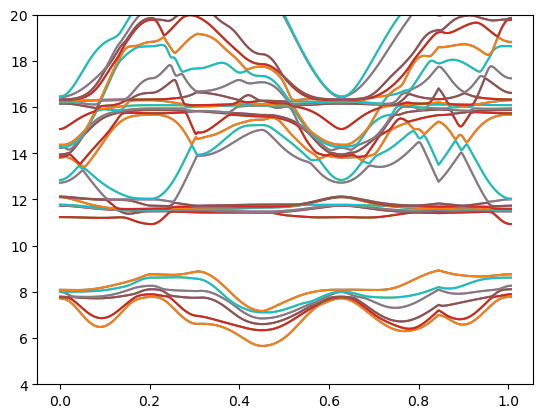

In [4]:
import matplotlib.pyplot as plt

plt.plot(xx, eigval)
plt.ylim(4,20)
plt.show()

In [5]:
from gGA.utils.make_kpoints import kmesh_sampling
import torch
from gGA.gutz import GhostGutzwiller
import numpy as np

%env PYTHONUNBUFFERED=1
%env OMP_NUM_THREADS=1

# setup_seed(1234)

torch.set_default_dtype(torch.float64)
U = 7.1
J = 0. # 0.25 * U
Up = U - 2*J
Jp = J

gga = GhostGutzwiller(
    atomic_number=np.array([63, 8]),
    nocc=11,
    basis={"Eu":"1d1f", "O":"1p"},
    idx_intorb={"Eu":[1]},
    naux=1,
    intparams={"Eu":[{"U":U,"Up":Up,"J":J, "Jp":Jp}]},
    nspin=4,
    kBT=0.0002,
    mutol=1e-4,
    solver="DMRG",
    decouple_bath=True,
    mixer_options={"method": "Linear", "a": 0.7},
    iscomplex=True,
    solver_options={"n_threads": 1, "nupdate":8, "bond_dim":500} # {"mfepmin":2000, "channels": 10, "Ptol": 1e-3},
)

data["kpoint"] = kmesh_sampling([8,8,8], True)

env: PYTHONUNBUFFERED=1
env: OMP_NUM_THREADS=1


In [ ]:
gga.run(data, 200, 1e-3)

DM_kin:  [4.20823653e-04 5.70880437e-04 6.27832550e-04 9.36851574e-04
 1.37233941e-03 1.96448131e-03 2.03872960e-03 2.60220670e-03
 3.20152731e-03 4.53620454e-03 5.14330999e-03 5.79049984e-03
 7.34147262e-03 9.35511415e-03 1.01574843e-02 1.25491976e-02
 5.66502364e-02 9.60475769e-02 5.81775134e-01 5.86028822e-01
 8.36207744e-01 8.67048041e-01 9.68899950e-01 9.79501608e-01
 9.84509298e-01 9.88445724e-01 9.93474216e-01 9.95886024e-01
 9.98220053e-01 9.98616252e-01]

Build MPO | Nsites =    28 | Nterms =        735 | Algorithm = FastBIP | Cutoff = 1.00e-14
 Site =     0 /    28 .. Mmpo =     4 DW = 0.00e+00 NNZ =        4 SPT = 0.0000 Tmvc = 0.000 T = 0.001
 Site =     1 /    28 .. Mmpo =     8 DW = 0.00e+00 NNZ =       10 SPT = 0.6875 Tmvc = 0.000 T = 0.001
 Site =     2 /    28 .. Mmpo =    11 DW = 0.00e+00 NNZ =       17 SPT = 0.8068 Tmvc = 0.000 T = 0.001
 Site =     3 /    28 .. Mmpo =    14 DW = 0.00e+00 NNZ =       23 SPT = 0.8506 Tmvc = 0.000 T = 0.001
 Site =     4 /    28 .. Mmp